--- Starting PHASE G: Threshold Optimization & PR Analysis ---


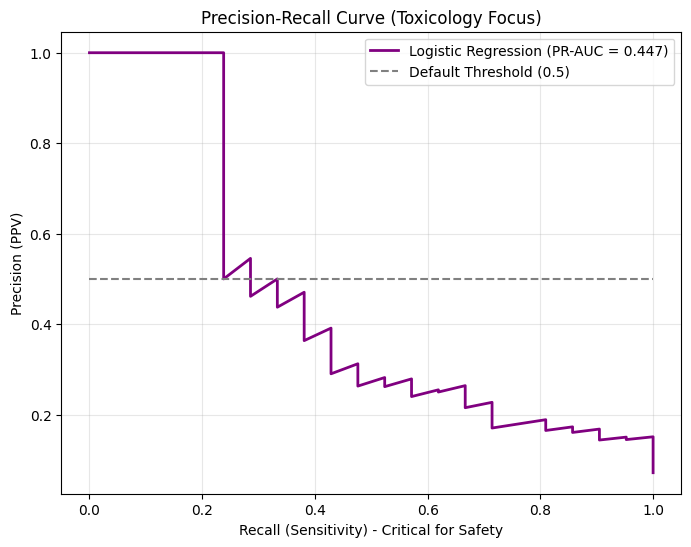


               THRESHOLD SWEEP ANALYSIS
Threshold  | Precision  | Recall     | F1-Score   | False Neg.
------------------------------------------------------------
0.05       | 0.1724     | 0.7143     | 0.2778     | 6         
0.10       | 0.2500     | 0.6667     | 0.3636     | 7         
0.15       | 0.2609     | 0.5714     | 0.3582     | 9         
0.20       | 0.2750     | 0.5238     | 0.3607     | 10        
0.25       | 0.2941     | 0.4762     | 0.3636     | 11        
0.30       | 0.3333     | 0.4286     | 0.3750     | 12        
0.35       | 0.3750     | 0.4286     | 0.4000     | 12        
0.40       | 0.3810     | 0.3810     | 0.3810     | 13        
0.45       | 0.3810     | 0.3810     | 0.3810     | 13        
0.50       | 0.4444     | 0.3810     | 0.4103     | 13        
0.55       | 0.4375     | 0.3333     | 0.3784     | 14        
0.60       | 0.4375     | 0.3333     | 0.3784     | 14        
0.65       | 0.5000     | 0.3333     | 0.4000     | 14        
0.70       | 0.4

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve, auc, confusion_matrix,
    precision_score, recall_score, f1_score
)

def run_phase_g():
    """
    Executes Phase G: Decision Threshold Optimization & PR Analysis.
    Focuses on identifying a safety-first operating point for toxicology.
    """
    print(f"--- Starting PHASE G: Threshold Optimization & PR Analysis ---")

    # 1. Defensive Programming: Verify Pre-conditions
    # We rely on artifacts from Phase F
    assert 'lr_model' in globals(), "CRITICAL ERROR: 'lr_model' not found. Run Phase F first."
    assert 'X_test' in globals(), "CRITICAL ERROR: 'X_test' not found. Run Phase F first."
    assert 'y_test' in globals(), "CRITICAL ERROR: 'y_test' not found. Run Phase F first."

    # 1. Prediction Probabilities
    # Extract probabilities for the Toxic class (1)
    y_probs = lr_model.predict_proba(X_test)[:, 1]

    # 2. Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall, precision)

    # 3. Plot Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Logistic Regression (PR-AUC = {pr_auc:.3f})', color='purple', lw=2)
    plt.plot([0, 1], [0.5, 0.5], linestyle='--', color='gray', label='Default Threshold (0.5)')

    plt.title('Precision-Recall Curve (Toxicology Focus)')
    plt.xlabel('Recall (Sensitivity) - Critical for Safety')
    plt.ylabel('Precision (PPV)')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.show()

    # 4. Threshold Sweep Analysis
    print(f"\n" + "="*60)
    print(f"               THRESHOLD SWEEP ANALYSIS")
    print(f"="*60)
    print(f"{'Threshold':<10} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10} | {'False Neg.':<10}")
    print(f"-"*60)

    sweep_thresholds = np.arange(0.05, 1.0, 0.05)

    # Variables to track optimization
    best_safety_threshold = 0.5
    min_false_negatives = float('inf')
    best_recall = 0.0

    for thresh in sweep_thresholds:
        # Generate hard predictions based on threshold
        y_pred_sweep = (y_probs >= thresh).astype(int)

        # Compute metrics
        prec = precision_score(y_test, y_pred_sweep, zero_division=0)
        rec = recall_score(y_test, y_pred_sweep, zero_division=0)
        f1 = f1_score(y_test, y_pred_sweep, zero_division=0)

        # Confusion matrix to get False Negatives
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_sweep).ravel()

        print(f"{thresh:<10.2f} | {prec:<10.4f} | {rec:<10.4f} | {f1:<10.4f} | {fn:<10}")

        # 5. Recall-First Threshold Selection Logic
        # We prioritize minimizing False Negatives (maximizing Recall).
        # Tie-breaker: If FN counts are equal, pick the one with higher Precision (implicit in higher threshold).
        # We define "Safety-First" as the threshold that yields the lowest FN
        # while keeping Precision non-trivial (> 0.1 to avoid predicting everything as toxic).

        if fn < min_false_negatives and prec > 0.05:
            min_false_negatives = fn
            best_safety_threshold = thresh
            best_recall = rec
        elif fn == min_false_negatives and prec > 0.05:
            # If FN is same, prefer higher precision (usually means higher threshold)
            # But strictly for safety, we often stick to the more conservative (lower) one?
            # Actually, if FN is same, we want higher precision to reduce False Alarms.
            # So we update if this threshold gives better precision (which it likely does as threshold increases).
             if prec > precision_score(y_test, (y_probs >= best_safety_threshold).astype(int), zero_division=0):
                 best_safety_threshold = thresh

    print(f"="*60)

    # 6. Evaluation at Optimized Threshold
    print(f"\n[Optimization Result]")
    print(f"Selected 'Safety-First' Threshold: {best_safety_threshold:.2f}")

    # Generate final predictions
    y_pred_opt = (y_probs >= best_safety_threshold).astype(int)

    # Comparison metrics
    tn_def, fp_def, fn_def, tp_def = confusion_matrix(y_test, lr_model.predict(X_test)).ravel()
    tn_opt, fp_opt, fn_opt, tp_opt = confusion_matrix(y_test, y_pred_opt).ravel()

    print(f"\n" + "="*45)
    print(f"       OPTIMIZED THRESHOLD PERFORMANCE")
    print(f"="*45)
    print(f"Recall (Toxic):          {recall_score(y_test, y_pred_opt):.4f}")
    print(f"Precision (Toxic):       {precision_score(y_test, y_pred_opt):.4f}")
    print(f"False Negatives (Count): {fn_opt} (Reduced from {fn_def})")
    print(f"="*45)

    print(f"\n[Confusion Matrix @ Threshold = {best_safety_threshold:.2f}]")
    print(f"                 Predicted 0   Predicted 1")
    print(f"Actual 0 (Safe)      {tn_opt:<5}         {fp_opt:<5}")
    print(f"Actual 1 (Toxic)     {fn_opt:<5}         {tp_opt:<5}")

    # 7. Scientific Interpretation (MANDATORY)
    print(f"\n" + "-"*60)
    print(f"SCIENTIFIC INTERPRETATION:")
    print(f"-"*60)
    print(f"1. Arbitrary Defaults vs. Safety:")
    print(f"   The default threshold of 0.5 missed {fn_def} toxic molecules.")
    print(f"   By lowering the threshold to {best_safety_threshold:.2f}, we reduced this to {fn_opt}.")
    print(f"   In toxicology, this is a necessary trade-off: we accept more False Positives")
    print(f"   (flagging safe drugs as toxic) to ensure we don't approve dangerous ones.")

    print(f"\n2. The Precision-Recall Trade-off:")
    print(f"   Notice that as Recall improved, Precision dropped.")
    print(f"   This means our 'Safety-First' model raises more false alarms.")
    print(f"   This is acceptable in early-stage screening, where secondary,")
    print(f"   more expensive tests (Phase II/III) can filter out the false alarms.")
    print(f"-"*60)

    return best_safety_threshold

# --- EXECUTION ---
optimal_threshold = run_phase_g()

print(f"\n--- PHASE G COMPLETED SUCCESSFULLY ---")